This notebook is to demonstrate the workflow for streaming detectors. This isn't indicative of performance with carefully selected parameters, just example input/output.

## Importing Libraries

In [1]:
import warnings
# warnings.simplefilter(action='ignore', category=FutureWarning)

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, roc_auc_score

## Circle Data

Synthetic data contains source 3 drift occuring from index 1000-1250 and affecting 66% of the data points. Data distribution based drift detectors can be applied to 'var1' or 'var 2'. For this example, error rate based detectors will use a Naive Bayes classifier. 

In [2]:
df = pd.read_csv('examples\Streaming\dataCircleGSev3Sp3Train.csv', usecols = [0,1,2],names = ['var1','var2','y'])

## Change Detection
These are more along the lines of change detection, where the user specified bounds outside which a given feature should not stray without alerting a user. Think "six-sigma."

#### Page Hinkley

In [3]:
from mendelaus.change_detection import PageHinkley

In [4]:
#setup one-directional PH test

ph = PageHinkley(delta=0.01, 
                threshold=15,
                direction='negative', 
                burn_in = 30)

# setup DF to record results
status = pd.DataFrame(columns=['index', 'actual value', 'drift_detected'])

# iterate through data and run PH
for i in range(len(df)):
    obs = df['var2'][i]
    ph.update(next_obs=obs, obs_id=i)
    status.loc[i] = [i, obs, ph.drift_state]

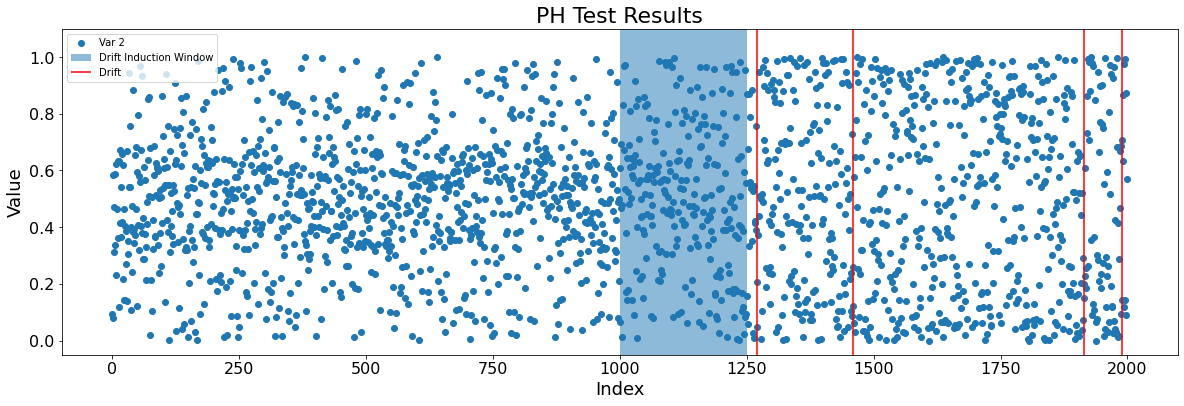

In [5]:
plt.figure(figsize=(20, 6))
plt.scatter('index', 'actual value', data=status, label='Var 2')
plt.grid(False, axis='x')
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.title('PH Test Results', fontsize=22)
plt.ylabel('Value', fontsize=18)
plt.xlabel('Index', fontsize=18)
plt.ylim([-0.05,1.1])

plt.axvspan(1000, 1250, alpha=0.5, label='Drift Induction Window')

for _, t in enumerate(status.loc[status['drift_detected'] == 'drift']['index']):
    plt.vlines(x=t, ymin=-0.05, ymax=1.1, colors='red', label=("Drift" if _ == 0 else None))
   
plt.legend()
plt.show()

#### CUSUM

In [6]:
from mendelaus.change_detection import CUSUM

In [7]:
cusum = CUSUM(target=np.mean(df.iloc[0:1000,1]), #mean / std of 'Var 2' pre-drift 
                sd_hat=np.std(df.iloc[0:1000,1]), 
                burn_in=50,
                delta=0.005,
                threshold=40,
                direction=None)

# setup DF to record results
status = pd.DataFrame(columns=['index', 'actual value', 'drift_detected'])

# iterate through data and run PH
for i in range(len(df)):
    obs = df['var2'][i]
    cusum.update(obs)
    status.loc[i] = [i, obs, cusum.drift_state]

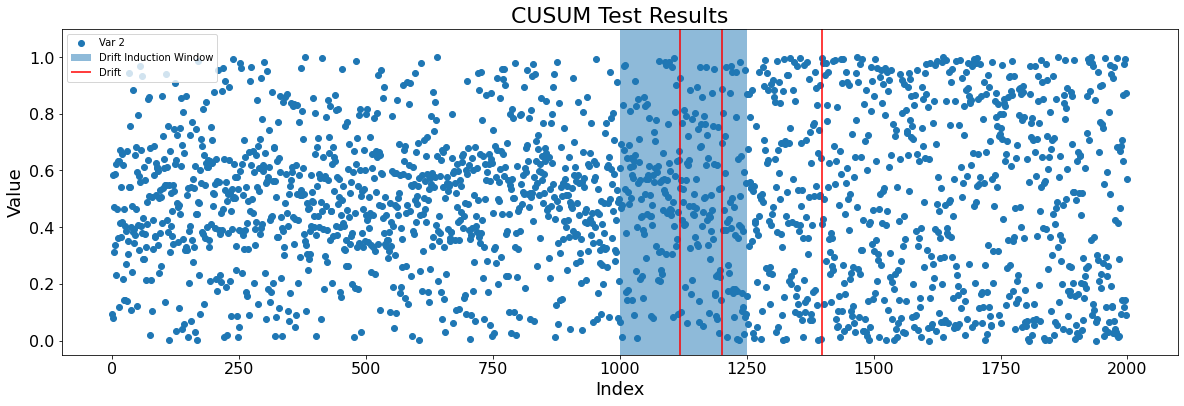

In [8]:
plt.figure(figsize=(20, 6))
plt.scatter('index', 'actual value', data=status, label='Var 2')
plt.grid(False, axis='x')
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.title('CUSUM Test Results', fontsize=22)
plt.ylabel('Value', fontsize=18)
plt.xlabel('Index', fontsize=18)
plt.ylim([-0.05,1.1])

plt.axvspan(1000, 1250, alpha=0.5, label='Drift Induction Window')

for _, t in enumerate(status.loc[status['drift_detected'] == 'drift']['index']):
    plt.vlines(x=t, ymin=-0.05, ymax=1.1, colors='red', label=("Drift" if _ == 0 else None))

plt.legend()
plt.show()

## Data drift
These detectors function by running across the entire feature set, one way or the other. They're not grounded in a model or its performance.


#### PCA-CD

In [9]:
from mendelaus.data_drift import PCACD
from sklearn.preprocessing import StandardScaler

In [10]:
#init PCA_CD
pca_cd = PCACD(window_size = 350, 
               delta = 0.05)

# setup DF to record results
status = pd.DataFrame(columns=['index', 'var1', 'var2', 'drift_detected'])

# iterate through X data and run PCA
data = df[['var1','var2']]
data = pd.DataFrame(StandardScaler().fit_transform(data))
for i in range(len(df)):
    pca_cd.update(data.iloc[[i]])
    status.loc[i] = [i, data.iloc[i,0], data.iloc[i,1], pca_cd.drift_state]

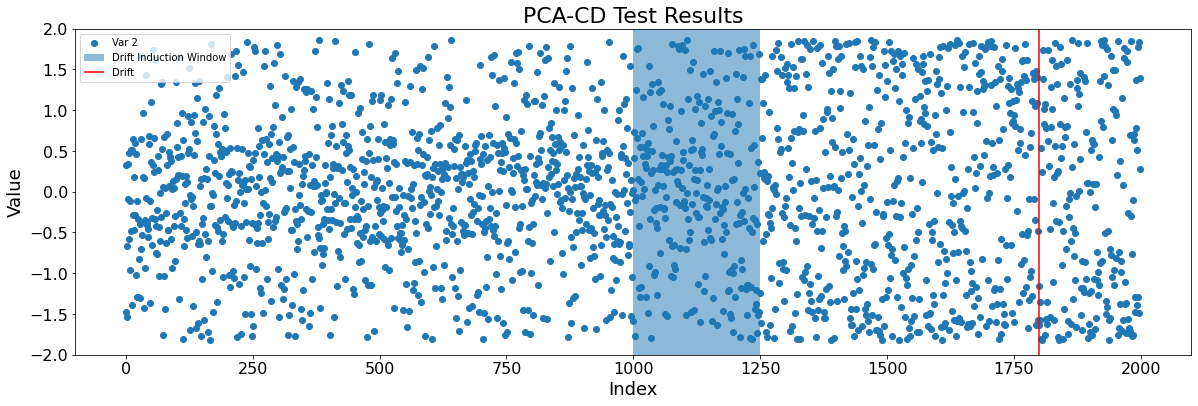

In [11]:
plt.figure(figsize=(20, 6))
plt.scatter('index', 'var2', data=status, label='Var 2')
plt.grid(False, axis='x')
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.title('PCA-CD Test Results', fontsize=22)
plt.ylabel('Value', fontsize=18)
plt.xlabel('Index', fontsize=18)
plt.ylim([-2,2])

plt.axvspan(1000, 1250, alpha=0.5, label='Drift Induction Window')

for _, t in enumerate(status.loc[status['drift_detected'] == 'drift']['index']):
    plt.vlines(x=t, ymin=-2, ymax=2, colors='red', label=("Drift" if _ == 0 else None))
   
plt.legend()
plt.show()

#### KDQ Tree

In [12]:
from mendelaus.data_drift import KdqTree

In [13]:
np.random.seed(123)

kdq = KdqTree(alpha=.05, 
            bootstrap_samples=500,
            window_size=300,
            count_ubound=50,
            persistence=.01,
            stream=True)

# setup DF to record results
status = pd.DataFrame(columns=['index', 'var1', 'var2', 'drift_detected'])

# iterate through X data and run KDQ tree
data = df[["var1", "var2"]]
for i in range(len(data)):
    kdq.update(data.iloc[[i]].values)
    status.loc[i] = [i, data.iloc[i, 0], data.iloc[i, 1], kdq.drift_state]

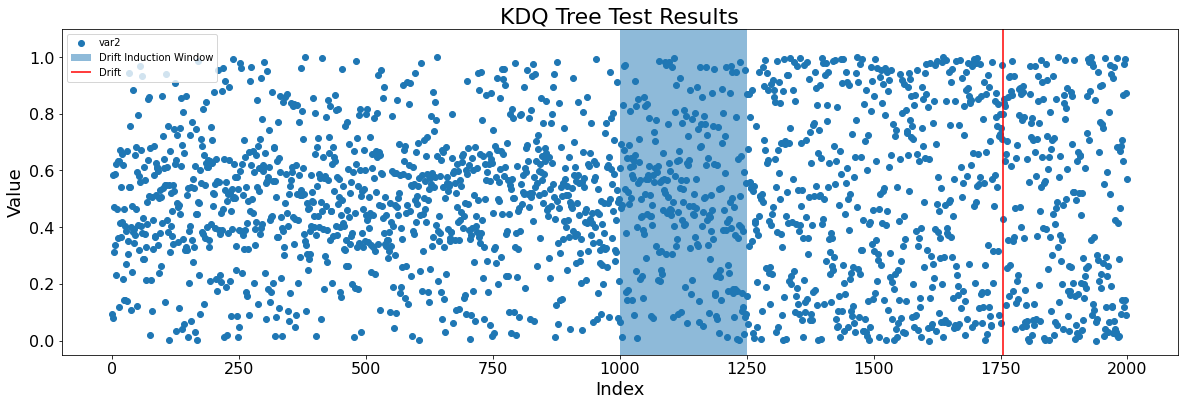

In [14]:
plt.figure(figsize=(20, 6))
plt.scatter('index', 'var2', data=status, label='var2')
plt.grid(False, axis='x')
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.title('KDQ Tree Test Results', fontsize=22)
plt.ylabel('Value', fontsize=18)
plt.xlabel('Index', fontsize=18)
plt.ylim([-0.05,1.1])

plt.axvspan(1000, 1250, alpha=0.5, label='Drift Induction Window')

for _, t in enumerate(status.loc[status['drift_detected'] == 'drift']['index']):
    plt.vlines(x=t, ymin=-2, ymax=2, colors='red', label=("Drift" if _ == 0 else None))
   
plt.legend()
plt.show()

### Concept drift (performance-based detectors)

These detectors monitor some measure of a given model's performance, and alarm when that performance degrades.

Naive Bayes Classifier train on first 500 rows of data, then apply to new samples. Retraining recommendations (printed in the for loop) are given as the indices of the suggested window, relative to the number of samples the detector has received -- so these are offset by 500 to respect the original dataframe.


#### Linear Four Rates

In [15]:
from mendelaus.concept_drift import LinearFourRates

In [16]:
# setup classifier: train on first 500 rows
X_train = df.iloc[0:500, 0:2]
y_train = df.iloc[0:500, 2]
clf = GaussianNB()
clf.fit(X_train, y_train)

lfr = LinearFourRates(time_decay_factor=0.6,
                        warning_level=0.01, 
                        detect_level=0.001, 
                        num_mc=5000, 
                        burn_in=10,
                        subsample=10)

#setup DF to store results
status = pd.DataFrame(columns=['index', 'y', 'y_pred', 'drift_detected','accuracy'])
correct = 0 

#run LFR and retrain
n = 1
for i in range(500, len(df)):
    np.random.seed(123)

    X_test = df.iloc[[i], 0:2]
    y_pred = int(clf.predict(X_test))
    y_true = int(df.iloc[[i], 2])
    
    #increment accuracy
    if y_pred == y_true:
        correct += 1
    accuracy = correct / n

    lfr.update(y_pred, y_true)
    status.loc[i] = [i, y_true, y_pred, lfr.drift_state, accuracy]

    # if drift, retrain. If not wanting to retrain, omit following block
    if lfr.drift_state == 'drift':

        retrain_start = lfr.retraining_recs[0] + 500 
        retrain_end = lfr.retraining_recs[1] + 500
        if retrain_start == retrain_end: #minimum retraining window for case of sudden drift
            retrain_start = max(0,retrain_start - 300)
        X_train = df.iloc[retrain_start:retrain_end,0:2]
        y_train = df.iloc[retrain_start:retrain_end, 2]
        clf = GaussianNB()
        clf.fit(X_train,y_train)
        print("Retrain Window: ", retrain_start, "-", retrain_end)
        
    n += 1

Retrain Window:  749 - 1049
Retrain Window:  1049 - 1349
Retrain Window:  1579 - 1819


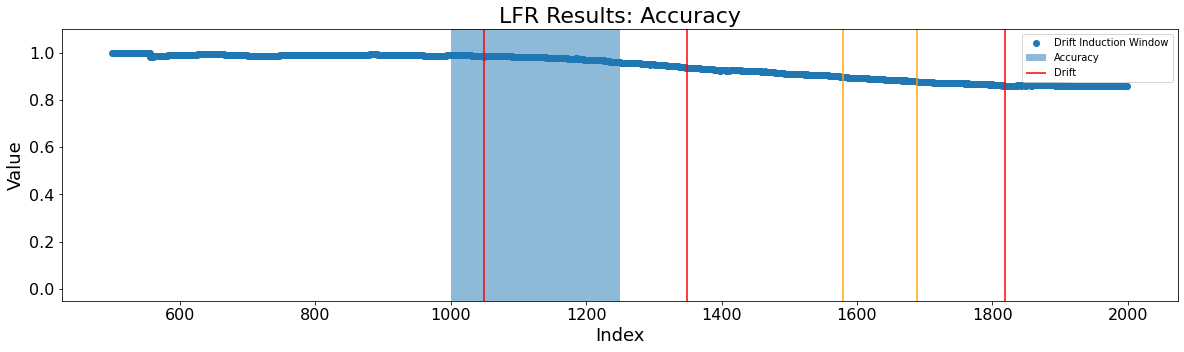

In [17]:
plt.figure(figsize=(20, 5))
plt.scatter('index', 'accuracy', data=status)
plt.grid(False, axis='x')
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.title('LFR Results: Accuracy', fontsize=22)
plt.ylabel('Value', fontsize=18)
plt.xlabel('Index', fontsize=18)
plt.ylim([-0.05,1.1])

plt.axvspan(1000, 1250, alpha=0.5, label='Drift Induction Window')

for _, t in enumerate(status.loc[status['drift_detected'] == 'drift']['index']):
    plt.vlines(x=t, ymin=-0.05, ymax=1.1, colors='red', label=("Drift" if _ == 0 else None))

for _, t in enumerate(status.loc[status['drift_detected'] == 'warning']['index']):
    plt.vlines(x=t, ymin=-0.05, ymax=1.1, colors='orange', label=("Warning" if _ == 0 else None))
 
plt.legend(['Drift Induction Window','Accuracy','Drift'])
plt.show()

#### ADWIN

In [18]:
from mendelaus.concept_drift import ADWIN

In [19]:
np.random.seed(123)
# setup classifier: train on first 500 rows
X_train = df.iloc[0:500, 0:2]
y_train = df.iloc[0:500, 2]
clf = GaussianNB()
clf.fit(X_train, y_train)

#setup ADWIN
adwin = ADWIN()

# setup DF to record results
status = pd.DataFrame(columns=['index', 'results', 'accuracy', 'adwin mean',  'drift_detected'])
correct = 0

# run ADWIN
n = 1
for i in range(500, len(df)):

    X_test = df.iloc[[i], 0:2]
    y_pred = int(clf.predict(X_test))
    y_true = int(df.iloc[[i], 2])

    # increment accuracy
    if y_pred == y_true:
        correct += 1
    accuracy = correct / n

    adwin.update(int(y_true == y_pred))
    status.loc[i] = [i, int(y_true==y_pred), accuracy, adwin.mean(), adwin.drift_state]

    # if drift, retrain. If not wanting to retrain, omit following block
    if adwin.drift_state == 'drift':
        retrain_start = adwin.retraining_recs[0] + 500
        retrain_end = adwin.retraining_recs[1] + 500
        X_train = df.iloc[retrain_start:retrain_end, 0:2]
        y_train = df.iloc[retrain_start:retrain_end, 2]
        clf = GaussianNB()
        clf.fit(X_train, y_train)
        print("Retrain Window: ", retrain_start, "-", retrain_end)

    n += 1

Retrain Window:  628 - 1267
Retrain Window:  756 - 1299
Retrain Window:  884 - 1331
Retrain Window:  948 - 1363
Retrain Window:  1012 - 1491


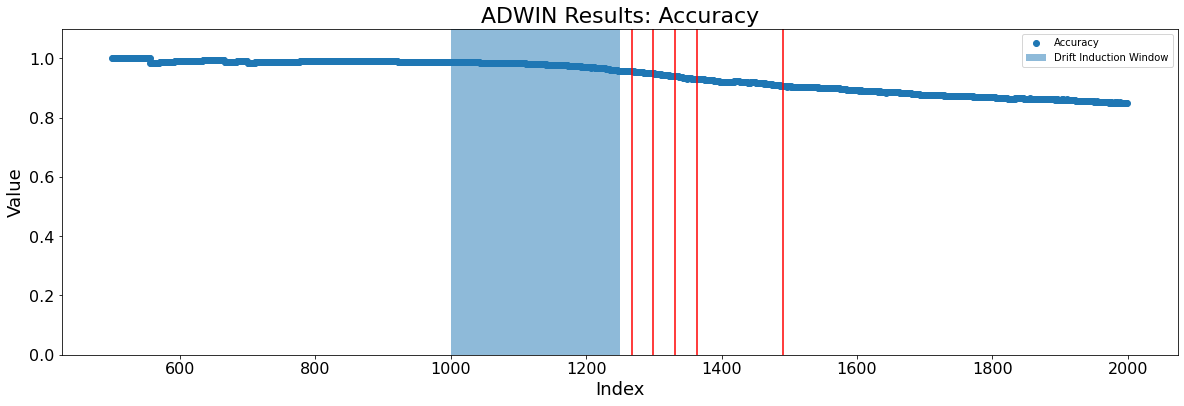

In [20]:
plt.figure(figsize=(20, 6))
plt.scatter('index', 'accuracy', data=status, label='Accuracy')
plt.grid(False, axis='x')
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.title('ADWIN Results: Accuracy', fontsize=22)
plt.ylabel('Value', fontsize=18)
plt.xlabel('Index', fontsize=18)
plt.ylim([0,1.1])

plt.axvspan(1000, 1250, alpha=0.5, label='Drift Induction Window')
#plt.vlines(x=status1.loc[retrain_end, 'index'], ymin=0, ymax=1.1, colors='green', linewidth = 7)

for _, t in enumerate(status.loc[status['drift_detected'] == 'drift']['index']):
    plt.vlines(x=t, ymin=0, ymax=1.1, colors='red')
    
plt.legend()   
plt.show()

#### STEPD

In [21]:
from mendelaus.concept_drift import STEPD

In [22]:
np.random.seed(123)
df_ex = df
train_ix = [0, 500]


clf = GaussianNB()
clf.fit(df_ex.iloc[train_ix[0]:train_ix[1], 0:2].values,
        df_ex.iloc[train_ix[0]:train_ix[1], 2].values)

GaussianNB()

In [23]:
#Note that this example is outside STEPD's intended use case.
#Its best performance would be with an online classifier that retrains incrementally on each new sample.

stepd = STEPD(window_size = 30, 
            alpha_warning = .05, 
            alpha_drift = .009)

# setup DF to store results
status = pd.DataFrame(columns=['index', 'y', 'y_pred', 'drift_detected', 'accuracy'])
correct = 0
n = 1

for i, row in df_ex.iloc[500:].iterrows():
    y_pred = clf.predict(np.array(row[0:2]).reshape(1, -1))
    y_true = row[2]
    
    if y_pred == y_true:
        correct += 1
    accuracy = correct / n
    
    stepd.update(y_pred, y_true)
    status.loc[i] = [i, y_true, y_pred, stepd.drift_state, accuracy]
    if stepd.drift_state == 'drift':
        #retrain the classifier using STEPD's recommendations
        train_ix = stepd.retraining_recs
    else:
        #update the classifier with the newest sample
        train_ix[1] = train_ix[1] + 1
    clf = GaussianNB()
    clf.fit(df_ex.iloc[train_ix[0]:train_ix[1], 0:2].values, 
            df_ex.iloc[train_ix[0]:train_ix[1], 2].values)
    
    n += 1

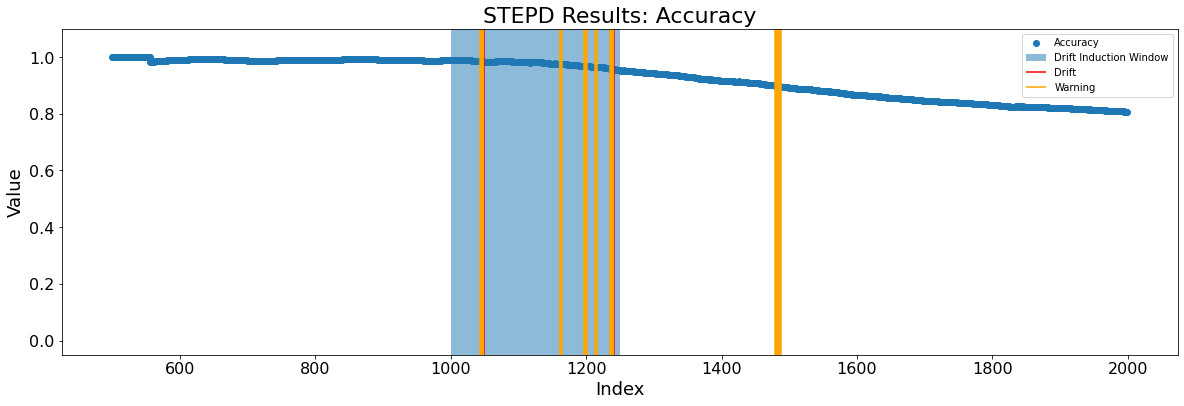

In [24]:
plt.figure(figsize=(20, 6))
plt.scatter('index', 'accuracy', data=status, label='Accuracy')
plt.grid(False, axis='x')
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.title('STEPD Results: Accuracy', fontsize=22)
plt.ylabel('Value', fontsize=18)
plt.xlabel('Index', fontsize=18)
plt.ylim([-0.05,1.1])

plt.axvspan(1000, 1250, alpha=0.5, label='Drift Induction Window')

for _, t in enumerate(status.loc[status['drift_detected'] == 'drift']['index']):
    plt.vlines(x=t, ymin=-0.05, ymax=1.1, colors='red', label=("Drift" if _ == 0 else None))

for _, t in enumerate(status.loc[status['drift_detected'] == 'warning']['index']):
    plt.vlines(x=t, ymin=-0.05, ymax=1.1, colors='orange', label=("Warning" if _ == 0 else None))
 
plt.legend()
plt.show()

#### EDDM

In [25]:
from mendelaus.concept_drift import EDDM

In [26]:
np.random.seed(123)
# setup classifier: train on first 500 rows
X_train = df.iloc[0:500, 0:2]
y_train = df.iloc[0:500, 2]
clf = GaussianNB()
clf.fit(X_train, y_train)

# setup STEPD
eddm = EDDM()

# setup DF to store results
status = pd.DataFrame(columns=['index', 'y', 'y_pred', 'drift_detected', 'accuracy'])
correct = 0

# run EDDM and retrain
n = 1
for i in range(500, len(df)):

    X_test = df.iloc[[i], 0:2]
    y_pred = int(clf.predict(X_test))
    y_true = int(df.iloc[[i], 2])

    # increment accuracy
    if y_pred == y_true:
        correct += 1
    accuracy = correct / n

    eddm.update(y_pred, y_true)
    status.loc[i] = [i, y_true, y_pred, eddm.drift_state, accuracy]

    # if drift, retrain. If not wanting to retrain, omit following block
    if eddm.drift_state == 'drift':
        retrain_start = eddm.retraining_recs[0] + 500
        retrain_end = eddm.retraining_recs[1] + 500
        if retrain_start == retrain_end: #minimum retraining window for case of sudden drift 
            retrain_start = max(0,retrain_start-300)
        X_train = df.iloc[retrain_start:retrain_end, 0:2]
        y_train = df.iloc[retrain_start:retrain_end, 2]
        clf = GaussianNB()
        clf.fit(X_train, y_train)
        print("Retrain Window: ", retrain_start, "-", retrain_end)

    n += 1

Retrain Window:  1247 - 1257
Retrain Window:  1042 - 1342
Retrain Window:  1179 - 1479
Retrain Window:  1337 - 1637
Retrain Window:  1549 - 1849


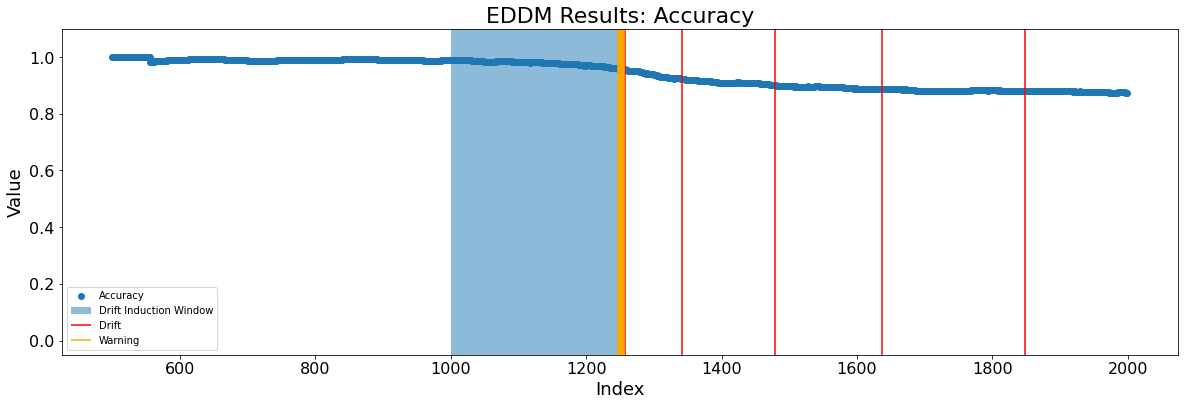

In [27]:
plt.figure(figsize=(20, 6))
plt.scatter('index', 'accuracy', data=status, label='Accuracy')
plt.grid(False, axis='x')
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.title('EDDM Results: Accuracy', fontsize=22)
plt.ylabel('Value', fontsize=18)
plt.xlabel('Index', fontsize=18)
plt.ylim([-0.05,1.1])

plt.axvspan(1000, 1250, alpha=0.5, label='Drift Induction Window')

for _, t in enumerate(status.loc[status['drift_detected'] == 'drift']['index']):
    plt.vlines(x=t, ymin=-0.05, ymax=1.1, colors='red', label=("Drift" if _ == 0 else None))
    
for _, t in enumerate(status.loc[status['drift_detected'] == 'warning']['index']):
    plt.vlines(x=t, ymin=-0.05, ymax=1.1, colors='orange', label=("Warning" if _ == 0 else None))
 
plt.legend()
plt.show()

#### DDM

In [28]:
from mendelaus.concept_drift import DDM

In [29]:
np.random.seed(123)
# setup classifier: train on first 500 rows
X_train = df.iloc[0:500, 0:2]
y_train = df.iloc[0:500, 2]
clf = GaussianNB()
clf.fit(X_train, y_train)

ddm = DDM(n_threshold = 100,
        warning_scale = 7, 
        drift_scale = 10)

# setup DF to store results
status = pd.DataFrame(columns=['index', 'y', 'y_pred', 'drift_detected', 'accuracy'])
correct = 0

# run EDDM and retrain
n = 1
for i in range(500, len(df)):

    X_test = df.iloc[[i], 0:2]
    y_pred = int(clf.predict(X_test))
    y_true = int(df.iloc[[i], 2])

    # increment accuracy
    if y_pred == y_true:
        correct += 1
    accuracy = correct / n

    ddm.update(y_pred, y_true)
    status.loc[i] = [i, y_true, y_pred, ddm.drift_state, accuracy]

    # if drift, retrain. If not wanting to retrain, omit following block
    if ddm.drift_state == 'drift':
        retrain_start = ddm.retraining_recs[0] + 500
        retrain_end = ddm.retraining_recs[1] + 500
        if retrain_start == retrain_end: #minimum retraining window for case of sudden drift 
            retrain_start = max(0,retrain_start-300)
        X_train = df.iloc[retrain_start:retrain_end, 0:2]
        y_train = df.iloc[retrain_start:retrain_end, 2]
        clf = GaussianNB()
        clf.fit(X_train, y_train)
        print("Retrain Window: ", retrain_start, "-", retrain_end)

    n += 1

Retrain Window:  1125 - 1201


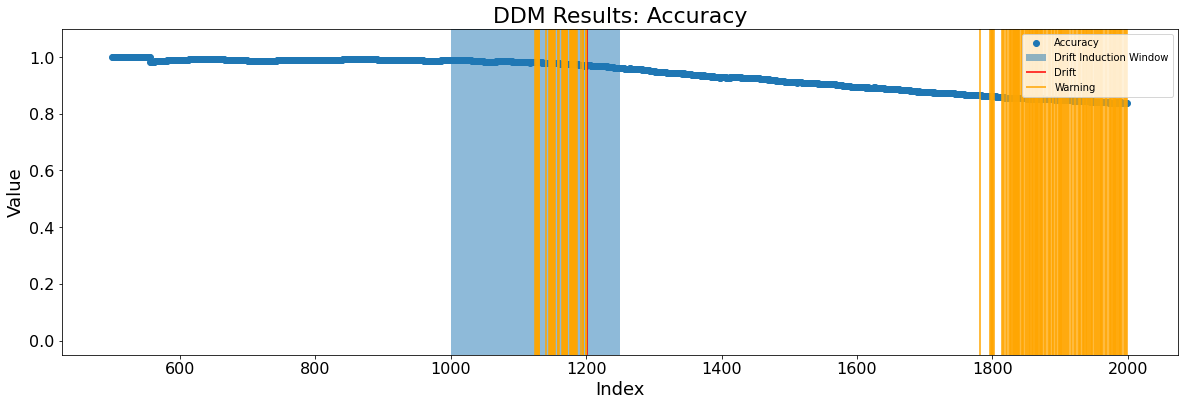

In [30]:
plt.figure(figsize=(20, 6))
plt.scatter('index', 'accuracy', data=status, label='Accuracy')
plt.grid(False, axis='x')
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.title('DDM Results: Accuracy', fontsize=22)
plt.ylabel('Value', fontsize=18)
plt.xlabel('Index', fontsize=18)
plt.ylim([-0.05,1.1])

plt.axvspan(1000, 1250, alpha=0.5, label='Drift Induction Window')

for _, t in enumerate(status.loc[status['drift_detected'] == 'drift']['index']):
    plt.vlines(x=t, ymin=-0.05, ymax=1.1, colors='red', label=("Drift" if _ == 0 else None))
    
for _, t in enumerate(status.loc[status['drift_detected'] == 'warning']['index']):
    plt.vlines(x=t, ymin=-0.05, ymax=1.1, colors='orange', label=("Warning" if _ == 0 else None))
 
plt.legend()
plt.show()